In [34]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataclasses import dataclass
import control as ct            # pip install control
from scipy.linalg import block_diag
from IPython.display import display

# PAPER = dict(
#     Ln=85.2e-6, Ls=12e-6, Lp=75.6e-6,
#     A=0.11,
#     eps_e={"n": 0.25, "s": 0.47, "p": 0.335},
#     D1=7.2296e-10,     # electrolyte diffusivity
#     Kappa=1.0794,      # (you’re not using this in Ae now; see §3)
#     sigmap=0.2029, sigman=150.5,
#     Dsp=5.2e-15, Dsn=3.975e-14,
#     kp=8.6225e-12, kn=5.9673e-13,
#     Rp_n=5.86e-6, Rp_p=5.22e-6,
#     csmax_n=29583.0, csmax_p=51765.0,
#     tplus=0.363,
#     theta_n0=0.90, theta_p0=0.27,
#     I_cc=5.0, Vmin=2.7, Vmax=4.2, dt=0.05
# )

params = dict(
    # solid diffusion blocks
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A_ln=1.0, A_lp=1.0,

    # geometry
    L1=25e-6, L2=20e-6, L3=25e-6,   # L_n, L_s, L_p

    # electrolyte transport (region-level — feel free to tie them together)
    D_e=7.23e-10,
    eps=0.30,
    A_e=1.0,
)


# =========================================================
# 0) Index map (states)
# x = [c_n1,c_n2,c_n3,c_n4,  c_p1,c_p2,c_p3,c_p4,  ce10,ce11,ce20,ce21,ce30,ce31]
# =========================================================
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),
    "cn_surf": 2,   # <- your chosen negative-electrode surface CV (adjust if needed)
    "cp_surf": 4,   # cp1 is at absolute index 4 (separator-side)
    "ce_left": 8,   # ce,1,0
    "ce_right": 13, # ce,3,1
}


STATE_NAMES = ['cn1','cn2','cn3','cn4','cp1','cp2','cp3','cp4','ce10','ce11','ce20','ce21','ce30','ce31']


# =========================================================
# 1) Physical constants & parameters
# =========================================================
@dataclass
class PhysParams:
    R: float = 8.314462618       # J/mol/K
    F: float = 96485.33212       # C/mol
    T: float = 298.15            # K
    t_plus: float = 0.38         # transference number
    kf: float = 1.0              # electrolyte factor in the log term
    Re: float = 0.0              # Ohmic electrolyte resistance
    Rf: float = 0.0              # FiLm (aging) resistance
    csn_max: float = 3.1e4       # [mol/m^3] (example)
    csp_max: float = 5.1e4       # [mol/m^3] (example)

PP = PhysParams()
# PP.t_plus = PAPER["tplus"]
# PP.csn_max = PAPER["csmax_n"]
# PP.csp_max = PAPER["csmax_p"]

print(t_plus := PP.t_plus, csn_max := PP.csn_max, csp_max := PP.csp_max)

# =========================================================
# 2) OCP and overpotential models (plug your fits here)
# =========================================================
# def ocp_p(theta: float) -> float:
#     """Positive-electrode OCP vs stoichiometry (V). Replace with your fit."""
#     return 4.0 - 0.1*np.tanh(8*(theta-0.5))  # placeholder

# def ocp_n(theta: float) -> float:
#     """Negative-electrode OCP vs stoichiometry (V). Replace with your fit."""
#     return 0.1 + 0.8*np.tanh(8*(theta-0.5))  # placeholder

# def eta_block(u: float, x: np.ndarray, kind="linear", Rct=0.0, alpha=0.5, I0=10.0):
#     """
#     Charge-transfer/kinetics overpotential η(I).
#       kind='none'|'linear'|'bv'
#     """
#     if kind == "none":
#         return 0.0
#     if kind == "linear":
#         return Rct*u
#     if kind == "bv":
#         # η = (2RT/αF) asinh(I / (2 I0))  [simple BV variant]
#         return (2*PP.R/(alpha*PP.F)*PP.T) * np.arcsinh(u/(2*I0))
#     raise ValueError("eta kind unknown")

# =========================================================
# 3) Block builders (A_n, B_n, A_p, B_p) — your 4×4 stencils
# =========================================================
# def build_An(Dn, Rn):
#     s = Dn/(Rn**2)
#     A = np.zeros((4,4))
#     A[0,0], A[0,1] = -24*s,  24*s
#     A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
#     A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
#     A[3,2], A[3,3] =  16*s, -16*s
#     return A

def build_An(Dn: float, Rn: float) -> np.ndarray:
    s = Dn / (Rn ** 2)
    A = np.zeros((4, 4))
    A[0, 0], A[0, 1] = -48 * s, 48 * s
    A[1, 0], A[1, 1], A[1, 2] = (48 / 7) * s, -(240 / 7) * s, (192 / 7) * s
    A[2, 1], A[2, 2], A[2, 3] = (192 / 19) * s, -(432 / 19) * s, (192 / 19) * s
    A[3, 2], A[3, 3] = (432 / 37) * s, -(432 / 37) * s
    return A



# def build_Bn(Dn, Rn, a, A, L_n):
#     b = np.zeros((4,1))
#     b[-1,0] = 6.0/(Rn*PP.F*a*Dn*A*L_n)
#     return b

def build_Bn(Rn: float, a: float, A_electrode: float, L_n: float) -> np.ndarray:
    """Return a 4x1 Bn vector (solid negative) — formula kept symbolic-like."""
    b = np.zeros((4,1))
    pi = 3.14159
    # use electrode area explicitly; keep sign positive for negative-electrode source
    b[-1,0] = (192*pi)/37 * (Rn * PP.F * a * A_electrode * L_n)
    return b



# def build_Ap(Dp, Rp):
#     s = Dp/(Rp**2)
#     A = np.zeros((4,4))
#     A[0,0], A[0,1] = -24*s,  24*s
#     A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
#     A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
#     A[3,2], A[3,3] =  16*s, -16*s
#     return A

def build_Ap(Dp: float, Rp: float) -> np.ndarray:
    s = Dp / (Rp ** 2)
    A = np.zeros((4, 4))
    A[0, 0], A[0, 1] = -48 * s, 48 * s
    A[1, 0], A[1, 1], A[1, 2] = (48 / 7) * s, -(240 / 7) * s, (192 / 7) * s
    A[2, 1], A[2, 2], A[2, 3] = (192 / 19) * s, -(432 / 19) * s, (192 / 19) * s
    A[3, 2], A[3, 3] = (432 / 37) * s, -(432 / 37) * s
    return A


# def build_Bp(Dp, Rp, a, A, L_p):
#     b = np.zeros((4,1))
#     b[-1,0] = 6.0/(Rp*PP.F*a*Dp*A*L_p)
#     return b

def build_Bp(Rp: float, a: float, A_electrode: float, L_p: float) -> np.ndarray:
    """Return a 4x1 Bp vector (solid positive). Keep sign opposite to Bn."""
    b = np.zeros((4,1))
    pi = 3.14159
    b[-1,0] = - (192*pi)/37 * (Rp * PP.F * a * A_electrode * L_p)
    return b


# =========================================================
# 4) Electrolyte blocks A_e, B_e
# =========================================================
def build_Ae(D_e, eps, Ln, Lsep, Lp):
    """
    6x6 electrolyte diffusion matrix for states:
      [ce10, ce11 | ce20, ce21 | ce30, ce31]
    Using coefficients exactly like your hand-written matrix:
      within region:  K*4/L^2
      interface:      K*16/(L_left + L_right)^2
    """
    
    K = D_e/eps
    Ae = np.zeros((6,6))

    w_in   = lambda L:  K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)

    w11 = w_in(Ln)                  # ce10<->ce11  (neg internal)
    w12 = w_intf(Ln, Lsep)          # ce11<->ce20  (neg-sep interface)
    w23 = w_in(Lsep)                # ce20<->ce21  (sep internal)
    w34 = w_intf(Lsep, Lp)          # ce21<->ce30  (sep-pos interface)
    w45 = w_in(Lp)                  # ce30<->ce31  (pos internal)

    # ce10
    Ae[0,1] = -w11
    Ae[0,0] = w11
    # ce11
    Ae[1,0] = -w11
    Ae[1,2] = -w12
    Ae[1,1] = (w11 + w12)
    # ce20
    Ae[2,1] =  -w12
    Ae[2,3] =  -w23
    Ae[2,2] =  (w12 + w23)
    # ce21
    Ae[3,2] =  -w23
    Ae[3,4] =  -w34
    Ae[3,3] =  (w23 + w34)
    # ce30
    Ae[4,3] =  -w34
    Ae[4,5] =  -w45
    Ae[4,4] =  (w34 + w45)
    # ce31
    Ae[5,4] =  -w45
    Ae[5,5] =  w45

    return Ae

# def build_Ae(D_e, epsilon, L_minus, Lsep, L_plus):
#     Ae = np.zeros((3,3))
#     K = D_e / epsilon

#     w_intf = lambda La, Lb: K * 4.0 / ((La + Lb)**2)

#     # Compute each region’s weight
#     w11 = w_intf(L_minus, Lsep)       # within negative electrode
#     w12 = w_intf(L_plus, Lsep)            # neg-sep interface


#     # Fill the 3x3 matrix
#     Ae[0,0] =  w11
#     Ae[0,1] = -w11
#     Ae[1,0] = -w11
#     Ae[1,1] =  (w11 + w12)
#     Ae[1,2] = -w12
#     Ae[2,1] = -w12
#     Ae[2,2] =  w12 

#     return Ae


# def build_Be(Ln, Lp, eps1, eps3, A, t_plus):
#     """
#     Distributed source in both electrode regions; zero in separator:
#     Be = [[ +(1-t+)/ (F A L1 eps1) ],
#           [ +(1-t+)/ (F A  L1 eps1) ],
#           [ 0 ],
#           [ 0 ],
#           [ sign_right*(1-t+)/ (F A L3 eps3) ],
#           [ sign_right*(1-t+)/ (F A L3 eps3) ]]
#     """
#     b = np.zeros((6,1))
#     s1 = (1.0 - t_plus) / (PP.F * A * Ln * eps1)
#     s3 = (1.0 - t_plus) / (PP.F * A * Lp * eps3)
#     b[0,0] = s1; b[1,0] = s1
#     b[4,0] = s3; b[5,0] = s3
#     return b

def build_Be(Ln, Lp, eps1, eps3, A, t_plus, sign_right=-1.0):
    b = np.zeros((6,1))
    s1 = +(1.0 - t_plus) / (PP.F * A * Ln * eps1)      # negative electrode: source
    s3 =  sign_right * (1.0 - t_plus) / (PP.F * A * Lp * eps3)  # positive electrode: sink (sign_right = -1)
    b[0,0] = s1; b[1,0] = s1
    b[4,0] = s3; b[5,0] = s3
    return b


# =========================================================
# 5) System assembly
# =========================================================
# def assemble_system(params):
#     # unpack
#     Dn,Rn = params["Dn"], params["Rn"]
#     Dp,Rp = params["Dp"], params["Rp"]
#     L1,L2,L3 = params["L1"], params["L2"], params["L3"]   # electrode,sep,electrode
#     a_s_n, a_s_p = params["a_s_n"], params["a_s_p"]
#     A_ln, A_lp   = params["A_ln"], params["A_lp"]         
#     A_e = params["A_e"]
#     # K = params["K"] if "K" in params else params["ke1"]   
#     # electrolyte transport (region-level)
#     D_e = params.get("De_n", params.get("De", 1e-10))
    
#     eps = params.get("eps", 0.3)
    
#     # A_e  = params.get("A_e", 1.0)

#     # sub-blocks (NOTE the added thickness args L1, L3)
#     An, Ap = build_An(Dn,Rn), build_Ap(Dp,Rp)
#     Bn, Bp = build_Bn(Rn, a_s_n, A, L1), build_Bp(Rp, a_s_p, A, L3)
#     Ae = build_Ae(D_e, eps, L1, L2, L3)
#     Be = build_Be(L1, L2, L3, eps, A_e, PP.t_plus)

#     # global A,B
#     A = block_diag(An, Ap, Ae)
#     B = np.vstack([Bn, Bp, Be])

#     C = np.eye(A.shape[0]); D = np.zeros((A.shape[0],1))
#     S = ct.ss(A,B,C,D)
#     return S, A, B, (An,Ap,Ae,Bn,Bp,Be)


def assemble_system(params):
    # unpack with defaults so missing keys don't KeyError
    Dn = params.get("Dn", 1e-14); Rn = params.get("Rn", 5e-6)
    Dp = params.get("Dp", 1e-14); Rp = params.get("Rp", 5e-6)
    L1 = params.get("L1", 25e-6); L2 = params.get("L2", 20e-6); L3 = params.get("L3", 25e-6)
    a_s_n = params.get("a_s_n", 1.0e6); a_s_p = params.get("a_s_p", 1.0e6)

    # electrode area (use either "A" or "A_e" from params; default 1.0)
    electrode_area = params.get("A", params.get("A_e", 1.0))
    # electrolyte scalar area/scale (if you meant something else, set params["A_e"])
    A_e_scale = params.get("A_e", electrode_area)

    D_e = params.get("D_e", params.get("De", 7.23e-10))
    eps = params.get("eps", 0.30)

    # build blocks
    An = build_An(Dn, Rn)
    Ap = build_Ap(Dp, Rp)
    Bn = build_Bn(Rn, a_s_n, electrode_area, L1)
    Bp = build_Bp(Rp, a_s_p, electrode_area, L3)

    Ae = build_Ae(D_e, eps, L1, L2, L3) # was K = D_e/eps
    Be = build_Be(L1, L3, eps, eps, electrode_area, PP.t_plus)

    # global A,B
    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])

    # auto-generate state names to match Aglob shape
    n_cn = An.shape[0]; n_cp = Ap.shape[0]; n_ce = Ae.shape[0]
    state_names = [f'cn{i+1}' for i in range(n_cn)] + \
                  [f'cp{i+1}' for i in range(n_cp)] + \
                  [f'ce{i+1}' for i in range(n_ce)]

    C = np.eye(Aglob.shape[0]); D = np.zeros((Aglob.shape[0],1))
    S = ct.ss(Aglob, Bglob, C, D)
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names


# =========================================================
# 6) Helpers: initial state, safe log, pretty printers
# =========================================================
# def safe_log_ratio(a, b, eps=1e-12):
#     return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))

# def safe_log_ratio(a, b, eps=1e-9):
#     return np.log(np.maximum(a, eps) / np.maximum(b, eps))

# After assemble_system(...)
# evals = np.linalg.eigvals(A)
# print("max Re(λ(A)) =", np.max(np.real(evals)))   # should be <= ~0

# def make_x0(pp=PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0):
#     x0 = np.zeros(14)
#     x0[IDX["cn"]] = theta_n0 * pp.csn_max
#     x0[IDX["cp"]] = theta_p0 * pp.csp_max
#     x0[IDX["ce"]] = ce0
#     return x0

# def make_x0(pp=PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0):
#     x0 = np.zeros(7)
#     x0[IDX["cn"]] = theta_n0 * pp.csn_max
#     x0[IDX["cp"]] = theta_p0 * pp.csp_max
#     x0[IDX["ce"]] = ce0
#     return x0

# def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B):
#     def df(M, rnames, cnames): return pd.DataFrame(M, index=rnames, columns=cnames)

#     display(df(An, [f'cn{i}' for i in range(1,5)], [f'cn{i}' for i in range(1,5)]))
#     display(df(Bn, [f'cn{i}' for i in range(1,5)], ['u']))

#     display(df(Ap, [f'cp{i}' for i in range(1,5)], [f'cp{i}' for i in range(1,5)]))
#     display(df(Bp, [f'cp{i}' for i in range(1,5)], ['u']))

#     display(df(Ae, ['ce10','ce11','ce20','ce21','ce30','ce31'],
#                   ['ce10','ce11','ce20','ce21','ce30','ce31']))
#     display(df(Be, ['ce10','ce11','ce20','ce21','ce30','ce31'], ['u']))

#     display(df(A, STATE_NAMES, STATE_NAMES))
#     display(df(B, STATE_NAMES, ['u']))
#     print("A shape:", A.shape, "  B shape:", B.shape)
    
    
def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B):
    def df(M, rnames, cnames): 
        return pd.DataFrame(M, index=rnames, columns=cnames)

    # solids are 2x2 now
    cn_names = [f'cn{i}' for i in range(1, An.shape[0]+1)]  # ['cn1','cn2']
    cp_names = [f'cp{i}' for i in range(1, Ap.shape[0]+1)]  # ['cp1','cp2']

    display(df(An, cn_names, cn_names))
    display(df(Bn, cn_names, ['u']))

    display(df(Ap, cp_names, cp_names))
    display(df(Bp, cp_names, ['u']))

    # electrolyte is 3x3 now
    ce_names = [f'ce{i}' for i in range(1, Ae.shape[0]+1)] # ['ce1','ce2','ce3']
    display(df(Ae, ce_names, ce_names))
    display(df(Be, ce_names, ['u']))

    # global
    display(df(A, STATE_NAMES, STATE_NAMES))
    display(df(B, STATE_NAMES, ['u']))
    print("A shape:", A.shape, "  B shape:", B.shape)
    


def plot_states_grouped(t: np.ndarray, X: np.ndarray):
    """
    Plot grouped state trajectories over time.
    
    Parameters
    ----------
    t : np.ndarray
        Time grid (T,)
    X : np.ndarray
        State matrix (T, n_states)
    """
    # Define plotting groups dynamically based on available states in IDX
    groups = {
        "Negative Electrode": [k for k in IDX if k.startswith("cn") or k.startswith("phi_n")],
        "Positive Electrode": [k for k in IDX if k.startswith("cp") or k.startswith("phi_p")],
        "Electrolyte": [k for k in IDX if k.startswith("ce") or k.startswith("phi_e")],
    }

    n_groups = len(groups)
    fig, axs = plt.subplots(n_groups, 1, figsize=(9, 3 * n_groups), sharex=True)

    if n_groups == 1:
        axs = [axs]  # make iterable

    for ax, (title, keys) in zip(axs, groups.items()):
        if not keys:
            continue
        ax.set_title(title, fontsize=12)
        for key in keys:
            ax.plot(t, X[:, IDX[key]], label=key)
        ax.set_ylabel("State value")
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, ncol=min(len(keys), 4))
    
    axs[-1].set_xlabel("Time [s]")
    plt.tight_layout()
    plt.show()


def report_extrema(X: np.ndarray):
    """
    Print min and max for each state group.
    
    Parameters
    ----------
    X : np.ndarray
        State matrix (T, n_states)
    """
    print("=== State Extrema Summary ===")
    for name, idx in IDX.items():
        arr = X[:, idx]
        vmin, vmax = np.min(arr), np.max(arr)
        print(f"{name:<8s}: min={vmin: .3e}, max={vmax: .3e}")


# =========================================================
# Example (run to test)
# =========================================================
if __name__ == "__main__":
    params = dict(
        Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
        a_s_n=1.0e6, a_s_p=1.0e6, A =1.0,
        L1=25e-6, L2=20e-6, L3=25e-6,
        D_e=7.23e-10, eps=0.30,
    )

    S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)
    show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)

    # Optional: view symbolic structure
    # show_symbolic_matrices()




0.38 31000.0 51000.0


,cn1,cn2,cn3,cn4
cn1,-0.019200,0.019200,0.000000,0.000000
cn2,0.002743,-0.013714,0.010971,0.000000
cn3,0.000000,0.004042,-0.009095,0.004042
cn4,0.000000,0.000000,0.004670,-0.004670


,u
cn1,0.000000
cn2,0.000000
cn3,0.000000
cn4,196.616662


,cp1,cp2,cp3,cp4
cp1,-0.019200,0.019200,0.000000,0.000000
cp2,0.002743,-0.013714,0.010971,0.000000
cp3,0.000000,0.004042,-0.009095,0.004042
cp4,0.000000,0.000000,0.004670,-0.004670


,u
cp1,0.000000
cp2,0.000000
cp3,0.000000
cp4,-196.616662


,ce1,ce2,ce3,ce4,ce5,ce6
ce1,15.424,-15.424000,0.000000,0.000000,0.000000,0.000
ce2,-15.424,34.465975,-19.041975,0.000000,0.000000,0.000
ce3,0.000,-19.041975,43.141975,-24.100000,0.000000,0.000
ce4,0.000,0.000000,-24.100000,43.141975,-19.041975,0.000
ce5,0.000,0.000000,0.000000,-19.041975,34.465975,-15.424
ce6,0.000,0.000000,0.000000,0.000000,-15.424000,15.424


,u
ce1,0.85678
ce2,0.85678
ce3,0.00000
ce4,0.00000
ce5,-0.85678
ce6,-0.85678


,cn1,cn2,cn3,cn4,cp1,cp2,cp3,cp4,ce10,ce11,ce20,ce21,ce30,ce31
cn1,-0.019200,0.019200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
cn2,0.002743,-0.013714,0.010971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
cn3,0.000000,0.004042,-0.009095,0.004042,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
cn4,0.000000,0.000000,0.004670,-0.004670,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
cp1,0.000000,0.000000,0.000000,0.000000,-0.019200,0.019200,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
cp2,0.000000,0.000000,0.000000,0.000000,0.002743,-0.013714,0.010971,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
cp3,0.000000,0.000000,0.000000,0.000000,0.000000,0.004042,-0.009095,0.004042,0.000,0.000000,0.000000,0.000000,0.000000,0.000
cp4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004670,-0.004670,0.000,0.000000,0.000000,0.000000,0.000000,0.000
ce10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.424,-15.424000,0.000000,0.000000,0.000000,0.000
ce11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.424,34.465975,-19.041975,0.000000,0.000000,0.000


,u
cn1,0.000000
cn2,0.000000
cn3,0.000000
cn4,196.616662
cp1,0.000000
cp2,0.000000
cp3,0.000000
cp4,-196.616662
ce10,0.856780
ce11,0.856780


A shape: (14, 14)   B shape: (14, 1)


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1199: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


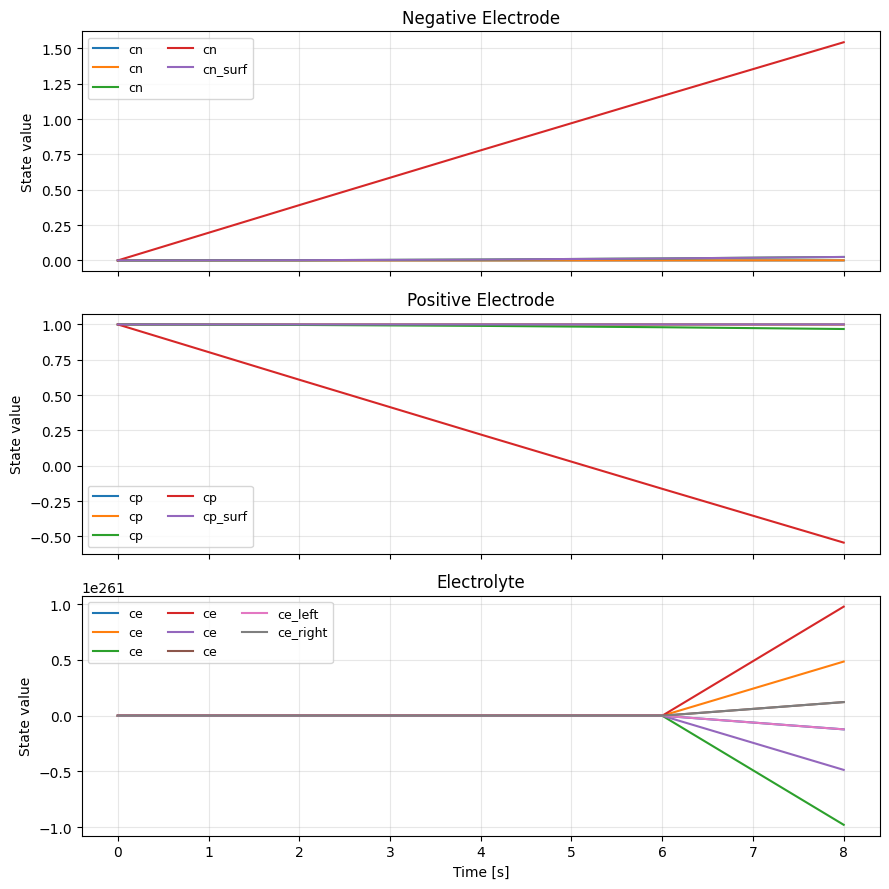

=== State Extrema Summary ===
cn      : min= nan, max= nan
cp      : min= nan, max= nan
ce      : min= nan, max= nan
cn_surf : min= nan, max= nan
cp_surf : min= nan, max= nan
ce_left : min= nan, max= nan
ce_right: min= nan, max= nan


In [ ]:
# ==============================
# 5) Simulation (forced_response)
# ==============================
def simulate_states_forced(A: np.ndarray, B: np.ndarray,
                           T: np.ndarray, U: np.ndarray, x0: np.ndarray) -> np.ndarray:
    """
    Simulate x' = A x + B u(t) with python-control forced_response.

    Returns
    -------
    X_TN : (T, n) state trajectory
    """
    sys = ct.ss(A, B, np.eye(A.shape[0]), 0)  # C = I so Y == X if needed
    resp = ct.forced_response(sys, T, U, X0=x0)
    if isinstance(resp, tuple) and len(resp) == 3:
        T_out, Y_out, X_out = resp
        X_TN = X_out.T
    else:
        T_out, Y_out = resp
        X_TN = Y_out.T  # because C = I
    assert X_TN.shape == (len(T), A.shape[0])
    return X_TN


# Time grid & input (SISO): U must be array with shape (len(T),) or (1,len(T))
T = np.linspace(0.0, 2000.0, 1001)  # seconds sample rate 100000
I_step = 0.001  # A
U = I_step * np.ones_like(T)        # <-- numeric array (not a function)

# Initial condition per your note: cn=0, cp=1, ce=0
x0 = np.zeros(A.shape[0])
x0[:4] = 0.0     # negative electrode
x0[4:8] = 1.0    # positive electrode
x0[8:] = 0.0     # electrolyte

# x0[IDX["cn"]] = 0.2
# x0[IDX["cp"]] = 0.9
# x0[IDX["ce"]] = 1000.0
    
# State-space with C = I (so outputs equal states), D = 0
sys = ct.ss(A, B, np.eye(A.shape[0]), np.zeros((A.shape[0], 1)))

# Forced response returns (T, Y, X)
resp = ct.forced_response(sys, T, U, X0=x0)

if isinstance(resp, tuple) and len(resp) == 3:
    T, Y, X = resp
    X_mat = X            # shape (n, len(T))
else:
    T, Y = resp
    X_mat = Y            # outputs == states since C = I

# Your plotting/reporting expect X as (len(T), n)
plot_states_grouped(T, X_mat.T)
report_extrema(X_mat.T)

# T_out, Y, X = ct.forced_response(sys, T, U, X0=x0)

# # X has shape (n, len(T)), so transpose for plotting
# X_mat = X.T
# plot_states_grouped(T_out, X_mat)
# report_extrema(X_mat)

In [31]:
# ============================
# 6) Voltage layer (two forms)
# ============================

# # example: polynomial OCPs (replace coeff arrays with yours)
# you’ll need chemistry-specific fits or your own OCV data.
# OCP_P_COEFFS = np.array([a5,a4,a3,a2,a1,a0])  # Up(xp) = a5 xp^5 + ... + a0
# OCP_N_COEFFS = np.array([b5,b4,b3,b2,b1,b0])  # Un(xn) = b5 xn^5 + ... + b0

# def ocp_p_poly(xp): return np.polyval(OCP_P_COEFFS, np.clip(xp,1e-6,1-1e-6))
# def ocp_n_poly(xn): return np.polyval(OCP_N_COEFFS, np.clip(xn,1e-6,1-1e-6))

# # then call:
# V_eq40, C_eq40 = voltage_eq40(T, XT, U_vec, vpar, ocp_p=ocp_p_poly, ocp_n=ocp_n_poly)
# V_espm, C_espm = voltage_espm(T, XT, U_vec, vpar, ocp_p=ocp_p_poly, ocp_n=ocp_n_poly)


# vpar.R_ohm = Re + Rf
# vpar.R_ohm = vpar.Re + vpar.Rf
# V_espm_no_ln, _ = voltage_espm(T, XT, U_vec, vpar, include_ln=False)




# ---- OCPs (safe placeholders). Replace with fits when ready. ----------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    """Cathode OCP [V], smooth & bounded for quick demos."""
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    """Anode OCP [V], smooth & bounded for quick demos."""
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

# ---- Voltage parameters -----------------------------------------------
@dataclass
class VParams:
    # geometry / area
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    # kinetics (tune for your cell)
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    # electrolyte & factors
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    nu_T: float = 1.0
    k_f: float = 1.0  # Eq.40 factor on ln term
    # ohmics
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    # temperature
    T: float = 298.15
    # interpretation of ce states
    ce_is_deviation: bool = True  # True ⇒ ce_actual = ce0 + ce_state

def _extract_surface_and_ce(X_TN: np.ndarray, vp: VParams):
    """
    Return surface stoichiometries and end electrolyte concentrations.
    ce handling: if `ce_is_deviation`, actual = ce0 + state.
    """
    xp = np.clip(X_TN[:, IDX["cp_surf"]], 1e-9, 1-1e-9)
    xn = np.clip(X_TN[:, IDX["cn_surf"]], 1e-9, 1-1e-9)
    ceL_raw = X_TN[:, IDX["ce_left"]]
    ceR_raw = X_TN[:, IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = np.clip(ceL, 1e-9, None)
    ceR = np.clip(ceR, 1e-9, None)
    return xp, xn, ceL, ceR

def _bv_eta_terms(I: np.ndarray, xp: np.ndarray, xn: np.ndarray,
                  ceL: np.ndarray, ceR: np.ndarray, vp: VParams):
    """
    Compute symmetric BV overpotentials via closed-form asinh.
    """
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = 0.5*(ceL + ceR)
    ce_kin = np.clip(ce_kin, 0.2*vp.ce0, 5.0*vp.ce0)  # guardrails for toy dynamics
    mp = I / (F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(xp*(1-xp)))
    mn = I / (F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(xn*(1-xn)))
    eta_p = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mp)
    eta_n = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mn)
    return eta_p, eta_n

def voltage_eq40(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
                 ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, ln_orientation: str = "right_over_left"):
    """
    Eq. 40 from your paper screenshot:
        V = U(x) + η(I) ± (2RT/F)(1-t⁺) k_f ln(ceR/ceL) − (Re+Rf) I
    We compute η(I) via BV asinh terms for identifiability and robustness.
    """
    I = np.asarray(I).reshape(-1)
    xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
    Up, Un = ocp_p(xp), ocp_n(xn)
    eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
    eta_sum = eta_p + eta_n

    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)
    ohmic  = -(vp.Re + vp.Rf) * I

    V = (Up - Un) + eta_sum + dphi_e + ohmic
    C = {"Udiff":Up-Un, "eta_sum":eta_sum, "dphi_e":dphi_e, "ohmic":ohmic, "V":V,
         "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}
    return V, C

# def voltage_espm(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
#                  ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, include_ln: bool = True):
#     """
#     ESPM/Review form:
#         V = Up−Un + 2RT/F[asinh(mp/2)+asinh(mn/2)]
#             + 2RT/F(1−t⁺)ν ln(ceR/ceL) − I R_ohm
#     """
#     I = np.asarray(I).reshape(-1)
#     xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
#     Up, Un = ocp_p(xp), ocp_n(xn)
#     eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
#     eta_sum = eta_p + eta_n
#     dphi_e  = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.nu_T * np.log(ceR/ceL) if include_ln else 0.0
#     ohmic   = -vp.R_ohm * I
#     V = (Up - Un) + eta_sum + dphi_e + ohmic
#     C = {"Udiff":Up-Un, "eta_p":eta_p, "eta_n":eta_n, "eta_sum":eta_sum,
#          "dphi_e":dphi_e, "ohmic":ohmic, "V":V, "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}
#     return V, C

# =========================
# 7) Voltage visual helpers
# =========================
def plot_voltage_compare(T, V1, V2, lab1="Eq.40", lab2="ESPM/Review"):
    """Overlay two voltage traces for quick comparison."""
    plt.figure(figsize=(9, 4.7))
    plt.plot(T, V1); plt.plot(T, V2)
    plt.xlabel("t [s]"); plt.ylabel("Voltage [V]")
    plt.title("Terminal voltage")
    # plt.legend([lab1, lab2]); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_voltage_contribs(T, C, title="Voltage contributions"):
    """Plot Udiff, η-sum, electrolyte ln-term, and ohmic."""
    plt.figure(figsize=(9, 4.7))
    plt.plot(T, C["Udiff"]); plt.plot(T, C["eta_sum"])
    if "dphi_e" in C: plt.plot(T, C["dphi_e"])
    if "ohmic"  in C: plt.plot(T, C["ohmic"])
    plt.xlabel("t [s]"); plt.ylabel("Contribution [V]")
    plt.title(title)
    labs = ["U_p - U_n","η_p + η_n","2RT(1-t⁺)…ln(ceR/ceL)","− I·R"]
    plt.legend(labs[:len(plt.gca().lines)]); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()






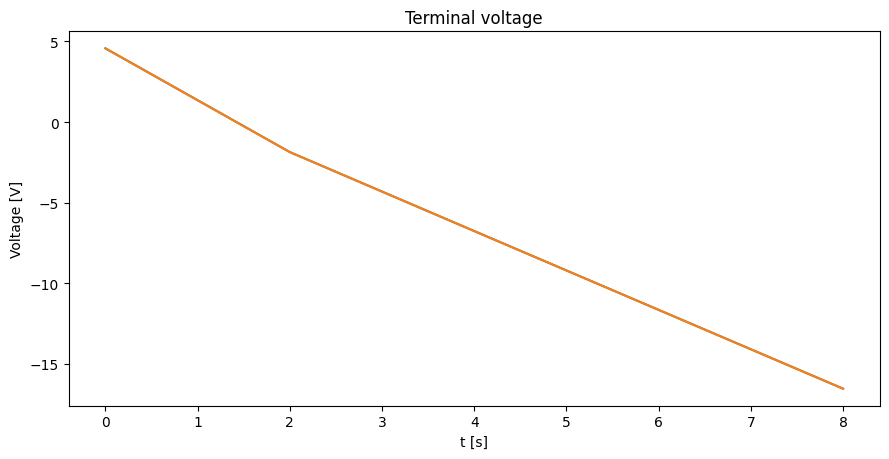

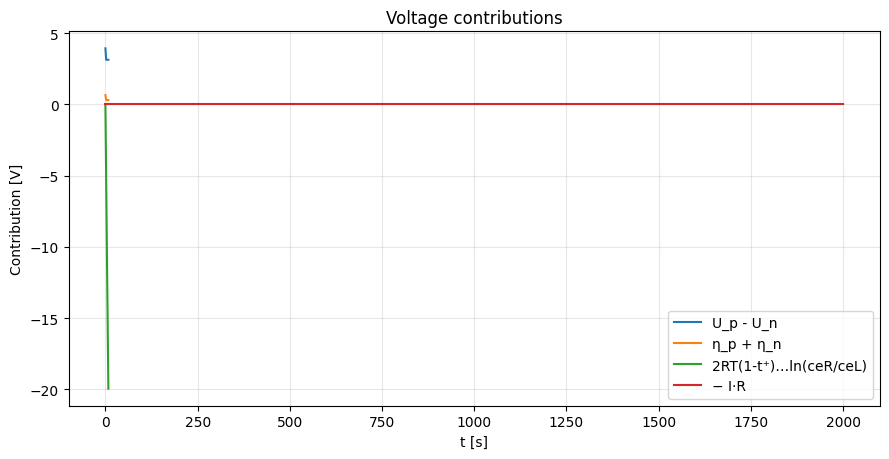

nan
max |residual| = 0.0


In [32]:
# ============================
# 8) Example (ready to run)
# ============================
R_GAS = 8.314462618        # J/(mol·K)
if __name__ == "__main__":
    # # --- Parameters (ballpark) ---
    # params = dict(
    #     Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    #     a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
    #     L1=25e-6, L2=20e-6, L3=25e-6,
    #     D_e=7.23e-10, eps=0.30,
    # )

    # # --- Assemble system ---
    # A, B, (An, Ap, Ae, Bn, Bp, Be) = assemble_system(params)
    # show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)

    # # --- Time, input (step), initial states ---
    # T = np.linspace(0.0, 2000.0, 1001)   # s
    # I_step = 1.0                         # A (discharge)
    # U = I_step * np.ones_like(T)         # (T,)

    # x0 = np.zeros(7)
    # x0[IDX["cn"]] = 0.0
    # x0[IDX["cp"]] = 1.0
    # x0[IDX["ce"]] = 0.0

    # --- Simulate ---
    X_TN = simulate_states_forced(A, B, T, U, x0)  # (T,7)
    
    
    # plot_states_grouped(T, X_TN)
    # report_extrema(X_TN)

    # --- Voltage params (tune to your cell) ---
    vpar = VParams(
        A=params["A"], L_n=params["L1"], L_p=params["L3"],
        a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
        k_n=2e-11, k_p=2e-11, cs_n_max=3.1e4, cs_p_max=5.1e4,
        ce0=1000.0, t_plus=PP.t_plus, nu_T=1.0, k_f=1.0,
        Re=0.0, Rf=0.0, R_ohm=0.0, T=298.15,
        ce_is_deviation=True
    )

    # --- Voltages (two forms) ---
    V_eq40, C_eq40   = voltage_eq40(T, X_TN, U, vpar, ln_orientation="L")
    # V_espm, C_espm   = voltage_espm(T, X_TN, U, vpar, include_ln=True)

    # --- Visuals ---
    # plot_voltage_compare(T, V_eq40, V_espm, lab1="Eq. 40", lab2="ESPM/Review")
    plot_voltage_compare(T, V_eq40, V_eq40, lab1="Eq. 40", lab2="ESPM/Review")
    
    plot_voltage_contribs(T, C_eq40, title="Voltage contributions")
    # plot_voltage_contribs(T, C_espm, title="ESPM/Review contributions")

residual = C_eq40["V"] - (C_eq40["Udiff"] + C_eq40["eta_sum"] + C_eq40.get("dphi_e", 0.0) + C_eq40.get("ohmic", 0.0))
print(np.max(np.abs(residual)))# should be very close to zero
print("max |residual| =", np.nanmax(np.abs(residual)))


In [33]:
# =========================================================
# 7) Output (voltage) nonlinearity and simulation
# =========================================================
def output_voltage(x: np.ndarray, u: float, pp: PhysParams = PP,
                   eta_kind="linear", Rct=0.0, I0=10.0):
    cn_surf = x[IDX["cn_surf"]]
    cp_surf = x[IDX["cp_surf"]]
    ce_left = x[IDX["ce_left"]]
    ce_right = x[IDX["ce_right"]]

    theta_p = np.clip(cp_surf/pp.csp_max, 1e-6, 1-1e-6)
    theta_n = np.clip(cn_surf/pp.csn_max, 1e-6, 1-1e-6)

    U = ocp_p(theta_p) - ocp_n(theta_n)
    log_term = -(2*pp.R*pp.T*(1-pp.t_plus)*pp.kf/pp.F) * safe_log_ratio(ce_left, ce_right)
    eta = eta_block(u, x, kind=eta_kind, Rct=Rct, I0=I0)
    return float(U + log_term + eta + (pp.Re + pp.Rf)*u)

def simulate(S, A, B, I_of_t, t, x0, eta_kind="linear", Rct=0.0, I0=10.0):
    U = I_of_t(t)                                  # shape (len(t),)
    tout, y_states, x_states = ct.forced_response(S, T=t, U=U, X0=x0, return_x=True)
    V = np.array([output_voltage(x_states[:,i], U[i], eta_kind=eta_kind, Rct=Rct, I0=I0)
                  for i in range(x_states.shape[1])])
    return tout, x_states, V

# =========================================================
# 8) Demo: assemble, inspect, simulate
# =========================================================
params = dict(
    # solid diffusion blocks
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A_ln=1.0, A_lp=1.0,
    # electrolyte geometry (Ln, Lsep, Lp)
    L1=25e-6, L2=20e-6, L3=25e-6,
    # electrolyte Be terms
    eps1=0.3, eps3=0.3, A_e=1.0,
    # Ae coefficient
    K=1e-10,           # K = De/epsilon (assumed constant across regions)
)

S, A, B, (An,Ap,Ae,Bn,Bp,Be) = assemble_system(params)

# optional: show matrices
# print_Be_formula(params["L1"], params["L3"], params["eps1"], params["eps3"], params["A_e"], PP.t_plus, sign_right=-1.0)
show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)

# input & ICs
t = np.linspace(0, 2000, 1001)
def I_of_t(tt): return np.ones_like(tt)*3.2  # A (step)
x0 = make_x0(PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0)

tout, X, V = simulate(S, A, B, I_of_t, t, x0, eta_kind="linear", Rct=0.002)


ValueError: too many values to unpack (expected 4)

In [ ]:
# =========================
# Voltage from existing X,U
# =========================

def ocp_from_weights(x_t, wn, wp, pp: PhysParams = PP):
    """OCP_p - OCP_n using linear weights over the 4 neg and 4 pos solid states."""
    cn = x_t[IDX["cn"]]  # (4,)
    cp = x_t[IDX["cp"]]  # (4,)
    cn_eff = float(wn @ cn)
    cp_eff = float(wp @ cp)
    theta_n = np.clip(cn_eff/pp.csn_max, 1e-6, 1-1e-6)
    theta_p = np.clip(cp_eff/pp.csp_max, 1e-6, 1-1e-6)
    return ocp_p(theta_p) - ocp_n(theta_n)

def voltage_terms_from_state(x_t: np.ndarray, u_t: float,
                             wn=None, wp=None,    # weights for U(·); None => your surface indices
                             eta_kind="linear", Rct=0.0, I0=10.0,
                             pp: PhysParams = PP):
    """
    Single time-step voltage with term breakdown:
      V = U(·)  - (2RT(1-t+)/F) k_f ln(ce_left/ce_right)  + η(I)  + (Re+Rf) I
    Returns dict with 'V', 'Uocp', 'log', 'eta', 'ohmic'.
    """
    # --- OCP term
    if (wn is None) or (wp is None):
        # fallback to your chosen "surface-like" indices
        cn_surf = x_t[IDX["cn_surf"]]
        cp_surf = x_t[IDX["cp_surf"]]
        theta_n = np.clip(cn_surf/pp.csn_max, 1e-6, 1-1e-6)
        theta_p = np.clip(cp_surf/pp.csp_max, 1e-6, 1-1e-6)
        Uocp = ocp_p(theta_p) - ocp_n(theta_n)
    else:
        wn = np.asarray(wn, dtype=float); wp = np.asarray(wp, dtype=float)
        if wn.sum() != 0: wn = wn/wn.sum()
        if wp.sum() != 0: wp = wp/wp.sum()
        Uocp = ocp_from_weights(x_t, wn, wp, pp)

    # --- electrolyte log term
    ce_left  = x_t[IDX["ce_left"]]   # C9  == ce,1,0
    ce_right = x_t[IDX["ce_right"]]  # C14 == ce,3,1
    log_term = -(2*pp.R*pp.T*(1-pp.t_plus)*pp.kf/pp.F) * safe_log_ratio(ce_left, ce_right)

    # --- kinetics & ohmics
    eta   = eta_block(u_t, x_t, kind=eta_kind, Rct=Rct, I0=I0)
    ohmic = (pp.Re + pp.Rf)*u_t

    V = float(Uocp + log_term + eta + ohmic)
    return {"V": V, "Uocp": float(Uocp), "log": float(log_term),
            "eta": float(eta), "ohmic": float(ohmic)}

def voltage_timeseries_from_XU(X: np.ndarray, U: np.ndarray,
                               wn=None, wp=None,
                               eta_kind="linear", Rct=0.0, I0=10.0,
                               pp: PhysParams = PP):
    """
    Vectorized wrapper over voltage_terms_from_state for an entire trajectory.
    X: (n_states, N)   U: (N,)
    Returns:
      V: (N,)
      terms: dict of arrays for 'Uocp','log','eta','ohmic'  (each (N,))
    """
    N = X.shape[1]
    V = np.empty(N)
    Uocp = np.empty(N); logv = np.empty(N); eta = np.empty(N); ohm = np.empty(N)
    for k in range(N):
        out = voltage_terms_from_state(X[:,k], U[k], wn=wn, wp=wp,
                                       eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)
        V[k]     = out["V"]
        Uocp[k]  = out["Uocp"]
        logv[k]  = out["log"]
        eta[k]   = out["eta"]
        ohm[k]   = out["ohmic"]
    terms = {"Uocp": Uocp, "log": logv, "eta": eta, "ohmic": ohm}
    return V, terms

# ---- “voltage at each state” views ------------------------------------------

def voltages_nodewise_timeseries(X: np.ndarray, U: np.ndarray,
                                 eta_kind="linear", Rct=0.0, I0=10.0,
                                 pp: PhysParams = PP,
                                 all_pairs=False):
    """
    Build alternative voltages by swapping which solid CVs feed the OCP.
    - V_neg_nodes[i,:]: use neg CV i with your default pos surface (cp index 0 -> absolute 4)
    - V_pos_nodes[j,:]: use pos CV j with your default neg surface (cn index 2)
    - If all_pairs=True, also return V_pairs[i,j,:] for every 4×4 combination.

    Returns dict with keys:
      'V_terminal' (your default choice),
      'V_neg_nodes' : (4, N),
      'V_pos_nodes' : (4, N),
      (optional) 'V_pairs'   : (4, 4, N)
    """
    N = X.shape[1]
    # default (surface/surface) terminal voltage
    V_terminal, _ = voltage_timeseries_from_XU(X, U, wn=None, wp=None,
                                               eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)

    # helper to make weights that pick a single node
    def onehot(k):
        w = np.zeros(4); w[k] = 1.0; return w

    # negative-node sweep (pair each neg node with your default pos surface cp_surf-> absolute 4 => local index 0)
    V_neg = np.empty((4, N))
    wp_surface = onehot(0)  # cp1 is the separator-side state in your layout
    for i in range(4):
        wn_i = onehot(i)
        V_neg[i,:], _ = voltage_timeseries_from_XU(X, U, wn=wn_i, wp=wp_surface,
                                                   eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)

    # positive-node sweep (pair each pos node with your default neg surface cn_surf-> local index 2)
    V_pos = np.empty((4, N))
    wn_surface = onehot(2)  # cn3 (index 2) is your neg surface-like state
    for j in range(4):
        wp_j = onehot(j)
        V_pos[j,:], _ = voltage_timeseries_from_XU(X, U, wn=wn_surface, wp=wp_j,
                                                   eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)

    out = {"V_terminal": V_terminal, "V_neg_nodes": V_neg, "V_pos_nodes": V_pos}

    if all_pairs:
        V_pairs = np.empty((4,4,N))
        for i in range(4):
            for j in range(4):
                V_pairs[i,j,:], _ = voltage_timeseries_from_XU(X, U, wn=onehot(i), wp=onehot(j),
                                                               eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)
        out["V_pairs"] = V_pairs
    return out


In [ ]:
# You already computed X, t
U_vec = I_of_t(t)

# Terminal voltage using your default surface indices (cn index 2, cp index 0):
V_term, terms = voltage_timeseries_from_XU(X, U_vec, eta_kind="linear", Rct=0.002)

# “Voltage at each state” views:
nodewise = voltages_nodewise_timeseries(X, U_vec, eta_kind="linear", Rct=0.002, all_pairs=False)
V_terminal = nodewise["V_terminal"]         # (N,)
V_neg_nodes = nodewise["V_neg_nodes"]       # (4, N)  i=0..3 => cn_i used
V_pos_nodes = nodewise["V_pos_nodes"]       # (4, N)  j=0..3 => cp_j used

# If you want the full 4×4 pair grid (optional):
# nodewise = voltages_nodewise_timeseries(X, U_vec, eta_kind="linear", Rct=0.002, all_pairs=True)
# V_pairs = nodewise["V_pairs"]  # (4,4,N)


Text(0.5, 1.0, 'Voltage term breakdown')

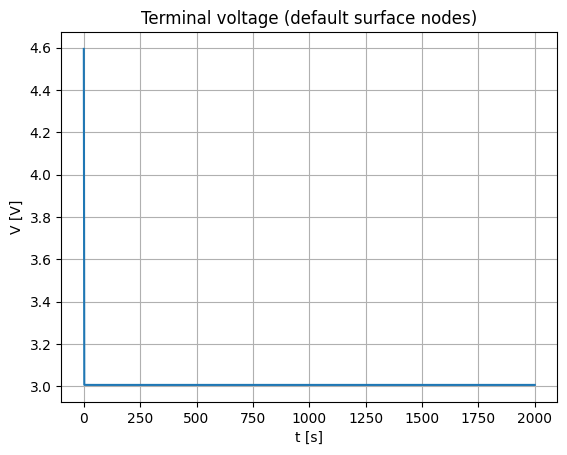

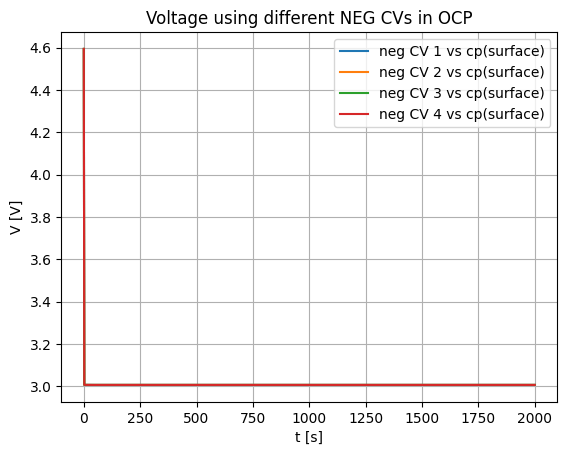

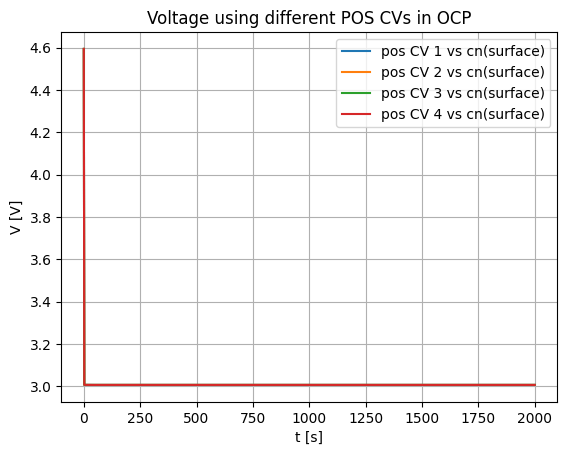

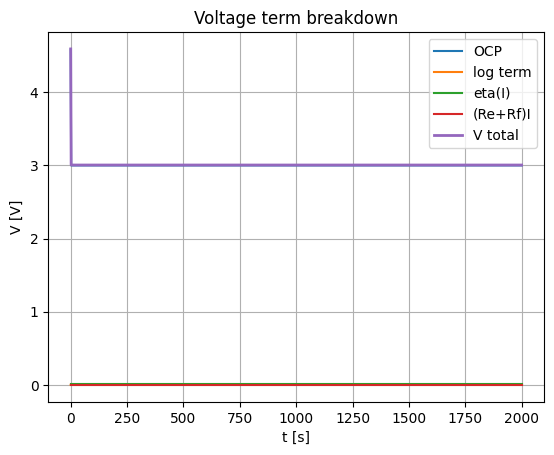

In [ ]:
import matplotlib.pyplot as plt

plt.figure(); plt.plot(t, V_term); plt.grid(True)
plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Terminal voltage (default surface nodes)")

# show how OCP node choice shifts V
plt.figure()
for i in range(4):
    plt.plot(t, V_neg_nodes[i,:], label=f"neg CV {i+1} vs cp(surface)")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage using different NEG CVs in OCP")

plt.figure()
for j in range(4):
    plt.plot(t, V_pos_nodes[j,:], label=f"pos CV {j+1} vs cn(surface)")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage using different POS CVs in OCP")

# breakdown
plt.figure()
plt.plot(t, terms["Uocp"], label="OCP")
plt.plot(t, terms["log"],  label="log term")
plt.plot(t, terms["eta"],  label="eta(I)")
plt.plot(t, terms["ohmic"],label="(Re+Rf)I")
plt.plot(t, V_term,        label="V total", linewidth=2)
plt.legend(); plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage term breakdown")


c_n  min/max: 5.92e+03 / 1.45e+17
c_p  min/max: 4.66e+04 / 1.45e+17
c_e  min/max: 986 / 1.01e+03  <-- should stay > 0


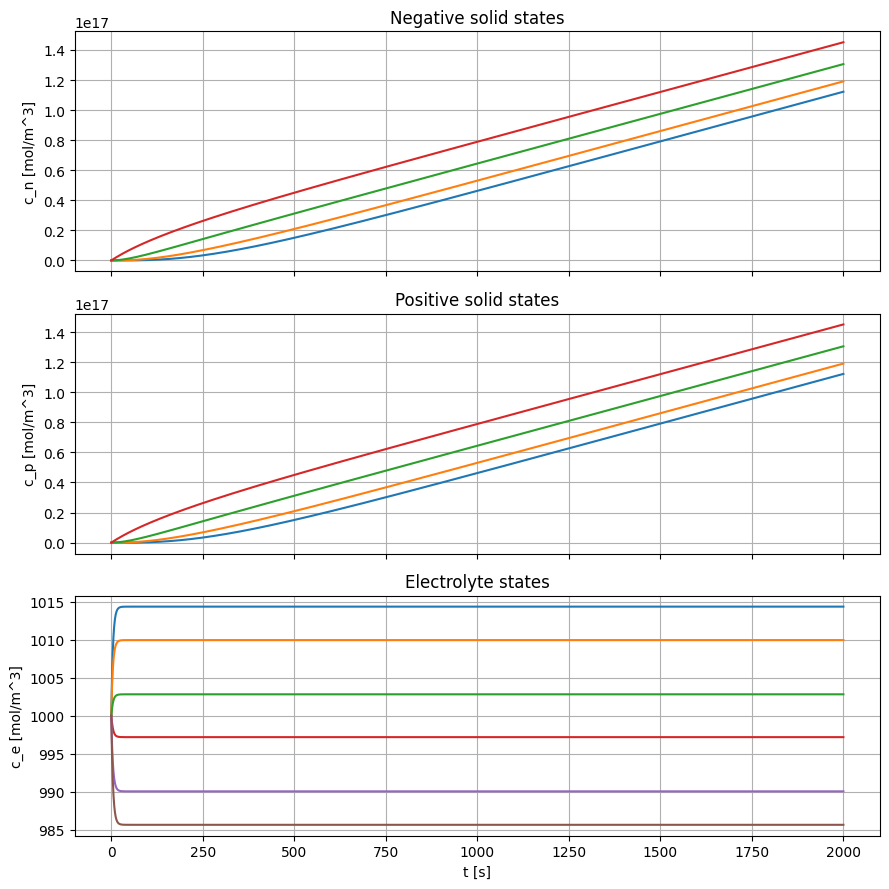

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_states(t, X):
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)

    # negative solid (4)
    axs[0].plot(t, X[IDX["cn"], :].T)
    axs[0].set_ylabel("c_n [mol/m^3]"); axs[0].grid(True)
    axs[0].set_title("Negative solid states")

    # positive solid (4)
    axs[1].plot(t, X[IDX["cp"], :].T)
    axs[1].set_ylabel("c_p [mol/m^3]"); axs[1].grid(True)
    axs[1].set_title("Positive solid states")

    # electrolyte (6)
    axs[2].plot(t, X[IDX["ce"], :].T)
    axs[2].set_ylabel("c_e [mol/m^3]"); axs[2].set_xlabel("t [s]"); axs[2].grid(True)
    axs[2].set_title("Electrolyte states")

    plt.tight_layout()

def report_extrema(X):
    def mm(arr): 
        return float(arr.min()), float(arr.max())
    cn_min, cn_max = mm(X[IDX["cn"], :])
    cp_min, cp_max = mm(X[IDX["cp"], :])
    ce_min, ce_max = mm(X[IDX["ce"], :])
    print(f"c_n  min/max: {cn_min:.3g} / {cn_max:.3g}")
    print(f"c_p  min/max: {cp_min:.3g} / {cp_max:.3g}")
    print(f"c_e  min/max: {ce_min:.3g} / {ce_max:.3g}  <-- should stay > 0")

plot_states(t, X)
report_extrema(X)


In [ ]:
def check_stability(A):
    lam = np.linalg.eigvals(A)
    max_real = np.max(np.real(lam))
    print("max Re(λ):", max_real)
    return lam

lam = check_stability(A)


max Re(λ): -4.489702961021306e-19


In [ ]:
from numpy.linalg import solve, LinAlgError

def dc_state(A, B, u):
    try:
        return -solve(A, B[:,0]*u)
    except LinAlgError:
        print("A is singular or ill-conditioned; DC state not well defined.")
        return None

u_ss = float(I_of_t(t[-1]))      # last value of your input
x_ss = dc_state(A, B, u_ss)
if x_ss is not None:
    err = np.linalg.norm(X[:,-1] - x_ss, ord=np.inf)
    print("||x(T_end) - x_ss||_inf =", err)


A is singular or ill-conditioned; DC state not well defined.


C:\Users\onyer\AppData\Local\Temp\ipykernel_46204\3826865238.py:214: RuntimeWarning: divide by zero encountered in log
  return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))


Text(0.5, 1.0, 'Terminal voltage (constructed from existing X, U)')

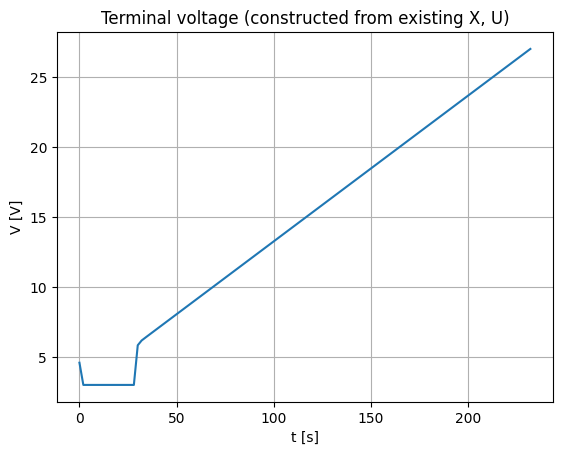

In [ ]:
U_vec = I_of_t(t)  # your input
V_term, terms = voltage_timeseries_from_XU(
    X, U_vec,
    wn=None, wp=None,             # default: your chosen surface indices
    eta_kind="linear", Rct=0.002  # or try "bv", I0=...
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, V_term); plt.grid(True)
plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Terminal voltage (constructed from existing X, U)")


In [ ]:
ce = np.maximum(X[IDX["ce"], :], 1e-9)


In [ ]:
# ===== U(·) aggregator for the OCP block =====================================

def make_U_aggregator(weights_n=None, weights_p=None, ocp_p_fun=ocp_p, ocp_n_fun=ocp_n):
    """
    Build a function U(x) = OCP_p(theta_p_eff) - OCP_n(theta_n_eff),
    where theta_eff are computed from linear combos of your 4 neg and 4 pos solid states.

    weights_n, weights_p: length-4 arrays that sum to 1 (we normalize anyway).
      e.g. to use the two near-surface neg nodes equally: [0, 0.5, 0.5, 0]
           to use a single 'surface' node: [0, 0, 1, 0]  (adjust to your layout)
    """
    # defaults: fall back to a single 'surface-like' node for each side
    wn = np.array([0, 0, 1, 0]) if weights_n is None else np.array(weights_n, dtype=float)
    wp = np.array([1, 0, 0, 0]) if weights_p is None else np.array(weights_p, dtype=float)

    # normalize if not zero
    if wn.sum() != 0: wn = wn / wn.sum()
    if wp.sum() != 0: wp = wp / wp.sum()

    def U_func(x, pp: PhysParams = PP):
        cn = x[IDX["cn"]]  # 4 neg solid states
        cp = x[IDX["cp"]]  # 4 pos solid states
        cn_eff = float(wn @ cn)
        cp_eff = float(wp @ cp)
        theta_n = np.clip(cn_eff/pp.csn_max, 1e-6, 1-1e-6)
        theta_p = np.clip(cp_eff/pp.csp_max, 1e-6, 1-1e-6)
        return ocp_p_fun(theta_p) - ocp_n_fun(theta_n)
    return U_func


# ===== Voltage map V(x,u) with flexible U(·) =================================

def voltage_from_state(x: np.ndarray, u: float,
                       U_func=None,          # callable built by make_U_aggregator; if None, use your earlier surface-choice
                       eta_kind="linear", Rct=0.0, I0=10.0,
                       pp: PhysParams = PP):
    # --- OCP term U(·)
    if U_func is None:
        # fallback: use your chosen "surface" indices
        cn_surf = x[IDX["cn_surf"]]
        cp_surf = x[IDX["cp_surf"]]
        theta_n = np.clip(cn_surf/pp.csn_max, 1e-6, 1-1e-6)
        theta_p = np.clip(cp_surf/pp.csp_max, 1e-6, 1-1e-6)
        U = ocp_p(theta_p) - ocp_n(theta_n)
    else:
        U = U_func(x)

    # --- electrolyte logarithmic term
    ce_left  = x[IDX["ce_left"]]   # ce,1,0
    ce_right = x[IDX["ce_right"]]  # ce,3,1
    log_term = -(2*pp.R*pp.T*(1-pp.t_plus)*pp.kf/pp.F) * safe_log_ratio(ce_left, ce_right)

    # --- kinetics & ohmics
    eta = eta_block(u, x, kind=eta_kind, Rct=Rct, I0=I0)   # this is your n(I_bat)
    ohmic = (pp.Re + pp.Rf)*u

    return float(U + log_term + eta + ohmic)


# ===== Simulation wrapper using the above voltage map =========================

def simulate_voltage(S, I_of_t, t, x0,
                     U_func=None,
                     eta_kind="linear", Rct=0.0, I0=10.0):
    """
    Simulate x(t) with the *linear* SS S, then form V(t) through the nonlinear
    output map voltage_from_state (Wiener structure).
    """
    U = I_of_t(t)
    tout, y_states, x_states = ct.forced_response(S, T=t, U=U, X0=x0, return_x=True)
    V = np.array([
        voltage_from_state(x_states[:, i], U[i], U_func=U_func,
                           eta_kind=eta_kind, Rct=Rct, I0=I0)
        for i in range(x_states.shape[1])
    ])
    return tout, x_states, V


In [ ]:
# Option A: OCP from single “surface-like” nodes (your previous behavior)
tout, X, V = simulate_voltage(S, I_of_t, t, x0, U_func=None, eta_kind="linear", Rct=0.002)

# Option B: OCP from *two* near-separator CVs per electrode (example weights)
Wn = np.array([0.0, 0.5, 0.5, 0.0])  # avg of cn2 & cn3
Wp = np.array([0.5, 0.5, 0.0, 0.0])  # avg of cp1 & cp2
U_func = make_U_aggregator(Wn, Wp)
tout, X, V = simulate_voltage(S, I_of_t, t, x0, U_func=U_func, eta_kind="bv", I0=10.0)


C:\Users\onyer\AppData\Local\Temp\ipykernel_4356\2170877980.py:195: RuntimeWarning: divide by zero encountered in log
  return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))


C:\Users\onyer\AppData\Local\Temp\ipykernel_4356\2170877980.py:195: RuntimeWarning: divide by zero encountered in log
  return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))


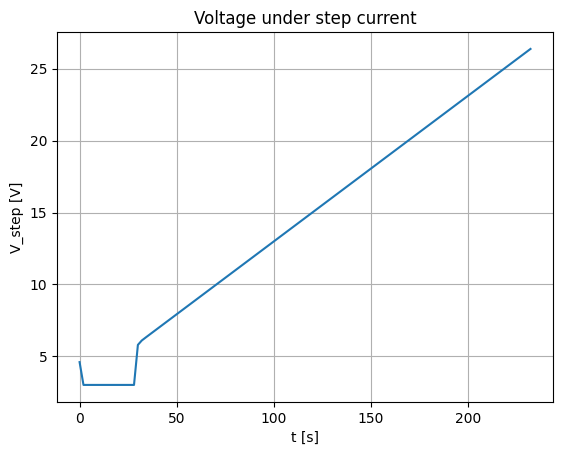

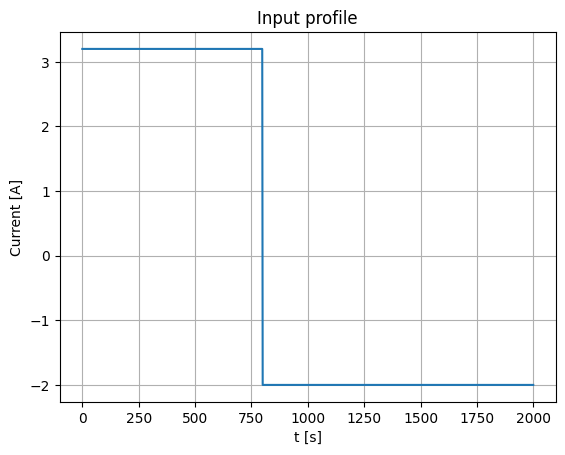

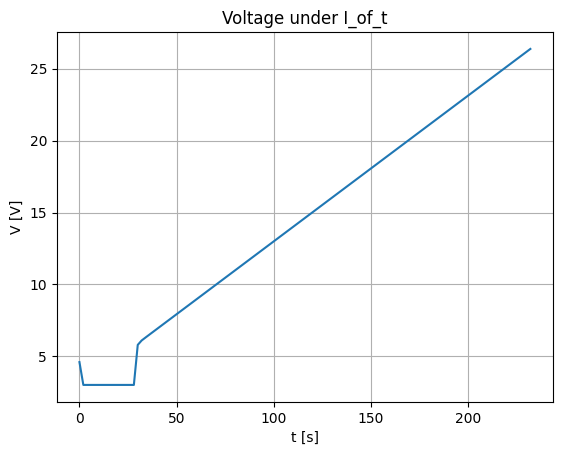

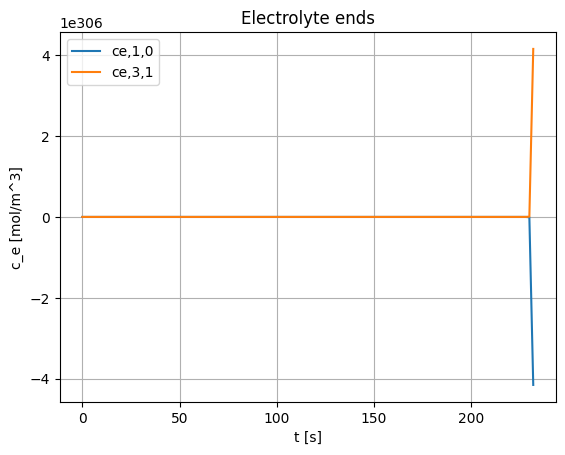

In [ ]:

# --- choose a step input for sanity checks
I_step = 3.2                   # [A] step amplitude (change as you like)
T = t                          
U_step = np.ones_like(T)*I_step
X0 = x0

# --- linear system with STATES as outputs (C = I), no direct feedthrough (D = 0)
C = np.eye(A.shape[0])
D = np.zeros((A.shape[0], 1))
NL = ct.ss(A, B, C, D)         

# --- linear response to STEP (use forced_response for MIMO safety)
Tout_step, Y_step, X_step = ct.forced_response(NL, T=T, U=U_step, X0=X0, return_x=True)
# Y_step == X_step because C = I

# --- build VOLTAGE from nonlinear static map V = g(x,u)
eta_kind = "linear"            # or "bv"
Rct = 2e-3                     # [Ohm] for eta_kind="linear"; ignored for "bv" except I0
I0  = 10.0                     # [A] BV scale if you use eta_kind="bv"

V_step = np.array([
    output_voltage(X_step[:, i], U_step[i], pp=PP, eta_kind=eta_kind, Rct=Rct, I0=I0)
    for i in range(X_step.shape[1])
])

# --- optional: a general input profile (ramp/pulse/etc.)
def I_of_t(tt):
    # example: 3.2 A for first 800 s, then -2 A
    return np.where(tt < 800.0, 3.2, -2.0)

U_forced = I_of_t(T)
Tout_forced, Y_forced, X_forced = ct.forced_response(NL, T=T, U=U_forced, X0=X0, return_x=True)

V_forced = np.array([
    output_voltage(X_forced[:, i], U_forced[i], pp=PP, eta_kind=eta_kind, Rct=Rct, I0=I0)
    for i in range(X_forced.shape[1])
])

# --- (optional) same thing using input_output_response (equivalent here)
# Yio = ct.input_output_response(NL, T, U_step, X0)
# X_io = Yio.y  # shape (n_outputs=14, len(T))
# V_step_io = np.array([output_voltage(X_io[:,i], U_step[i], pp=PP, eta_kind=eta_kind, Rct=Rct, I0=I0)
#                       for i in range(X_io.shape[1])])

# --- (optional) classic step_response of a single state channel (SISO slice)
# k = IDX["ce_left"]                    # e.g., ce10 response
# NL_k = NL[k, 0]                       # output k, input 0
# T_siso, yk = ct.step_response(NL_k, T=T)  # SISO step; no need for X0 here

# ===== quick looks ============================================================
import matplotlib.pyplot as plt

# Voltage under step
plt.figure()
plt.plot(Tout_step, V_step)
plt.xlabel("t [s]"); plt.ylabel("V_step [V]"); plt.title("Voltage under step current"); plt.grid(True)

# Voltage under general input
plt.figure()
plt.plot(T, U_forced, label="I(t)")
plt.xlabel("t [s]"); plt.ylabel("Current [A]"); plt.title("Input profile"); plt.grid(True)

plt.figure()
plt.plot(Tout_forced, V_forced)
plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Voltage under I_of_t"); plt.grid(True)

# Electrolyte end concentrations (sanity: enter/exit log term)
plt.figure()
plt.plot(Tout_forced, X_forced[IDX["ce_left"], :],  label="ce,1,0")
plt.plot(Tout_forced, X_forced[IDX["ce_right"], :], label="ce,3,1")
plt.xlabel("t [s]"); plt.ylabel("c_e [mol/m^3]"); plt.title("Electrolyte ends"); plt.legend(); plt.grid(True)


In [ ]:
# ================== GLUE: one-liners to run/inspect/plot =====================

def build_U_func(weights=None):
    """
    weights: None or (weights_n, weights_p) each of length-4.
      - None => your fallback surface indices (cn[2], cp[0])
      - Example: ([0,0.5,0.5,0],[0.5,0.5,0,0]) averages two near-separator CVs.
    """
    if weights is None:
        return None
    wn, wp = weights
    return make_U_aggregator(wn, wp, ocp_p_fun=ocp_p, ocp_n_fun=ocp_n)

def run_case(params, x0, t, I_of_t,
             weights=None,           # (Wn, Wp) or None
             eta_kind="linear", Rct=2e-3, I0=10.0):
    """
    Assemble the model, pick U(·), simulate x(t) and V(t).
    Returns: tout, X, V, blocks, system
      where blocks = (An, Ap, Ae, Bn, Bp, Be) and system = (S, A, B)
    """
    S, A, B, blocks = assemble_system(params)
    U_func = build_U_func(weights)
    tout, X, V = simulate_voltage(S, I_of_t, t, x0,
                                  U_func=U_func, eta_kind=eta_kind, Rct=Rct, I0=I0)
    return tout, X, V, blocks, (S, A, B)

def quick_plots(t, U, tout, V, X=None, show_ce=True):
    import matplotlib.pyplot as plt
    plt.figure(); plt.plot(t, U); plt.xlabel("t [s]"); plt.ylabel("I(t) [A]")
    plt.title("Input current"); plt.grid(True)

    plt.figure(); plt.plot(tout, V)
    plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.title("Terminal voltage"); plt.grid(True)

    if show_ce and X is not None:
        plt.figure()
        plt.plot(tout, X[IDX["ce_left"], :],  label="c_e,1,0")
        plt.plot(tout, X[IDX["ce_right"], :], label="c_e,3,1")
        plt.xlabel("t [s]"); plt.ylabel("c_e [mol/m^3]")
        plt.title("Electrolyte end concentrations"); plt.legend(); plt.grid(True)

def view_blocks(blocks, A, B):
    """Pretty print all blocks and assembled A,B (uses your show_matrices under the hood)."""
    An, Ap, Ae, Bn, Bp, Be = blocks
    show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)


C:\Users\onyer\AppData\Local\Temp\ipykernel_4356\2170877980.py:195: RuntimeWarning: divide by zero encountered in log
  return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))


,cn1,cn2,cn3,cn4
cn1,-0.0096,0.0096,0.0000,0.0000
cn2,0.0064,-0.0160,0.0096,0.0000
cn3,0.0000,0.0064,-0.0160,0.0096
cn4,0.0000,0.0000,0.0064,-0.0064


,u
cn1,0.000000e+00
cn2,0.000000e+00
cn3,0.000000e+00
cn4,4.974849e+13


,cp1,cp2,cp3,cp4
cp1,-0.0096,0.0096,0.0000,0.0000
cp2,0.0064,-0.0160,0.0096,0.0000
cp3,0.0000,0.0064,-0.0160,0.0096
cp4,0.0000,0.0000,0.0064,-0.0064


,u
cp1,0.000000e+00
cp2,0.000000e+00
cp3,0.000000e+00
cp4,4.974849e+13


,ce10,ce11,ce20,ce21,ce30,ce31
ce10,0.64,-0.640000,0.000000,0.000000,0.000000,0.00
ce11,-0.64,1.430123,-0.790123,0.000000,0.000000,0.00
ce20,0.00,-0.790123,1.790123,-1.000000,0.000000,0.00
ce21,0.00,0.000000,-1.000000,1.790123,-0.790123,0.00
ce30,0.00,0.000000,0.000000,-0.790123,1.430123,-0.64
ce31,0.00,0.000000,0.000000,0.000000,-0.640000,0.64


,u
ce10,0.85678
ce11,0.85678
ce20,0.00000
ce21,0.00000
ce30,0.85678
ce31,0.85678


,cn1,cn2,cn3,cn4,cp1,cp2,cp3,cp4,ce10,ce11,ce20,ce21,ce30,ce31
cn1,-0.0096,0.0096,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
cn2,0.0064,-0.0160,0.0096,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
cn3,0.0000,0.0064,-0.0160,0.0096,0.0000,0.0000,0.0000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
cn4,0.0000,0.0000,0.0064,-0.0064,0.0000,0.0000,0.0000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
cp1,0.0000,0.0000,0.0000,0.0000,-0.0096,0.0096,0.0000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
cp2,0.0000,0.0000,0.0000,0.0000,0.0064,-0.0160,0.0096,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
cp3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0064,-0.0160,0.0096,0.00,0.000000,0.000000,0.000000,0.000000,0.00
cp4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0064,-0.0064,0.00,0.000000,0.000000,0.000000,0.000000,0.00
ce10,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.64,-0.640000,0.000000,0.000000,0.000000,0.00
ce11,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.64,1.430123,-0.790123,0.000000,0.000000,0.00


,u
cn1,0.000000e+00
cn2,0.000000e+00
cn3,0.000000e+00
cn4,4.974849e+13
cp1,0.000000e+00
cp2,0.000000e+00
cp3,0.000000e+00
cp4,4.974849e+13
ce10,8.567796e-01
ce11,8.567796e-01


A shape: (14, 14)   B shape: (14, 1)


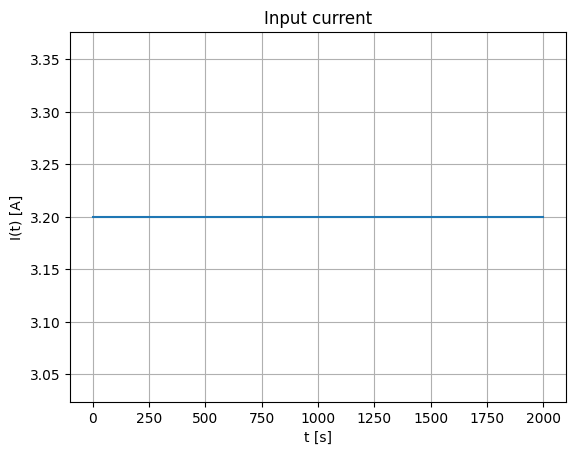

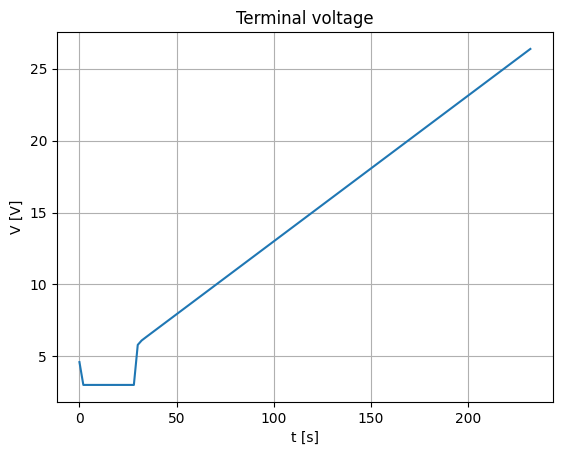

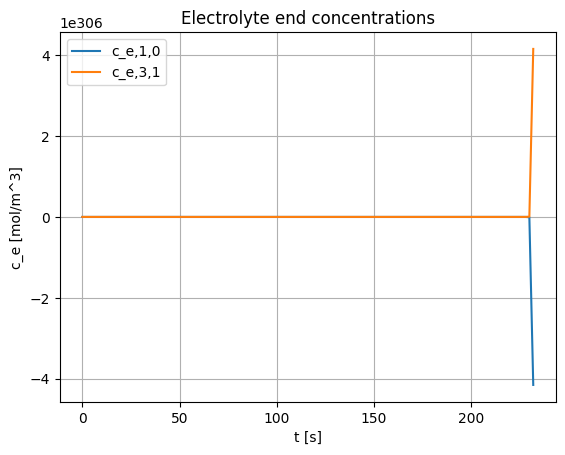

In [ ]:
# time & step input
t = np.linspace(0, 2000, 1001)
I_step = 3.2
def I_of_t_step(tt): return np.ones_like(tt) * I_step

# initial state
x0 = make_x0(PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0)

# params (use yours or the tuned set we discussed earlier)
params = dict(
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A_ln=1.0, A_lp=1.0,
    L1=25e-6, L2=20e-6, L3=25e-6,
    eps1=0.3, eps3=0.3, A_e=1.0,
    K=1e-10,
)

# run with baseline U(·) = single surface nodes (your original behavior)
tout, X, V, blocks, (S,A,B) = run_case(params, x0, t, I_of_t_step,
                                       weights=None,
                                       eta_kind="linear", Rct=2e-3)

# inspect matrices if you like
view_blocks(blocks, A, B)

# quick plots
U_vec = I_of_t_step(t)
quick_plots(t, U_vec, tout, V, X)


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1199: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U
C:\Users\onyer\AppData\Local\Temp\ipykernel_4356\2170877980.py:195: RuntimeWarning: divide by zero encountered in log
  return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))


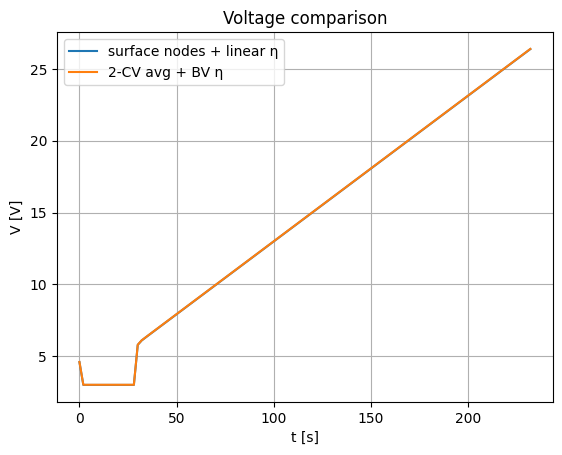

In [ ]:
# choose weights for U(·):
Wn = np.array([0.0, 0.5, 0.5, 0.0])  # average cn2 & cn3
Wp = np.array([0.5, 0.5, 0.0, 0.0])  # average cp1 & cp2

tout2, X2, V2, _, _ = run_case(params, x0, t, I_of_t_step,
                               weights=(Wn, Wp),
                               eta_kind="bv", I0=10.0)

# overlay voltages
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tout,  V,  label="surface nodes + linear η")
plt.plot(tout2, V2, label="2-CV avg + BV η")
plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Voltage comparison")
plt.grid(True); plt.legend()


C:\Users\onyer\AppData\Local\Temp\ipykernel_4356\2170877980.py:195: RuntimeWarning: divide by zero encountered in log
  return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))


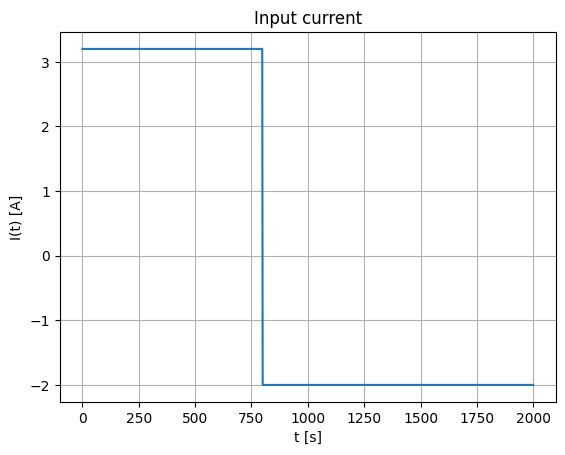

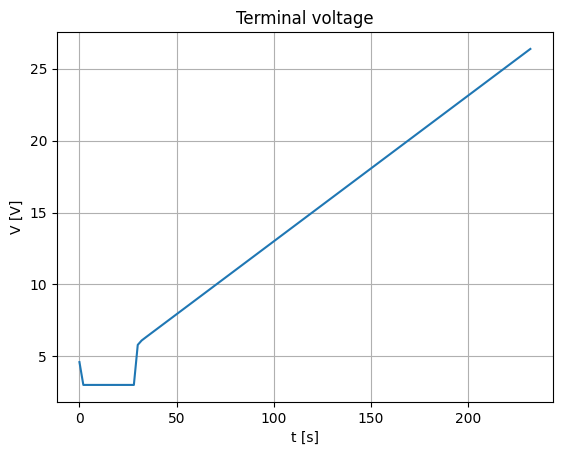

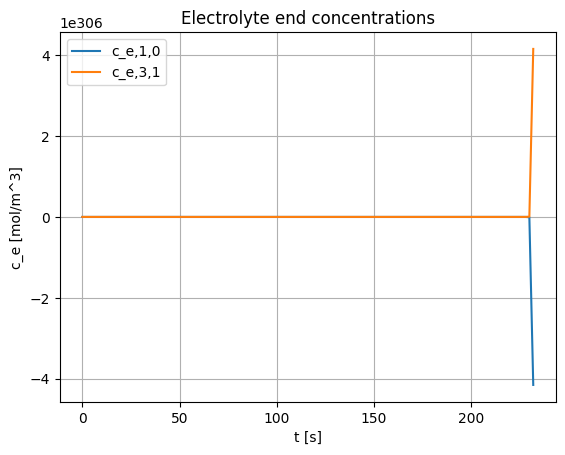

In [ ]:
def I_of_t(tt):
    # example: +3.2 A until 800 s, then -2 A
    return np.where(tt < 800.0, 3.2, -2.0)

tout3, X3, V3, _, _ = run_case(params, x0, t, I_of_t,
                               weights=None,
                               eta_kind="linear", Rct=2e-3)

quick_plots(t, I_of_t(t), tout3, V3, X3)


In [ ]:
C = np.eye(A.shape[0]); D = np.zeros((A.shape[0],1))
NL = ct.ss(A, B, C, D)
# x(t) from a given U(t)
Tout_lin, Y_lin, X_lin = ct.forced_response(NL, T=t, U=I_of_t(t), X0=x0, return_x=True)
# then V(t) by mapping (your output_voltage or voltage_from_state)


In [ ]:
U = np.ones(1000)
T = t
X0 = x0
# Code C
C = np.eye(A.shape[0])
D = np.zeros((A.shape[0],1))
NL = ct.ss(A, B, C, D)  

# Y = ct.input_output_response(NL, T, U, X0)

X = ct.step_response(NL, T, X0)

# print(X)

# Code V

# Look at the step response and see if it matches your expectations

# V_nl = Y.y[0]

In [ ]:
print(X.y.shape)

(14, 1, 1001)


In [ ]:
def f_update(x, u, t, params):   # linear state ODE
    (A, B) = params["A"], params["B"]
    return (A @ x.reshape(-1,1) + B*u).ravel()

def g_output(x, u, t, params):
    return [output_voltage(x, float(u), eta_kind=params.get("eta_kind","linear"),
                           Rct=params.get("Rct",0.0), I0=params.get("I0",10.0))]

def build_nl_iosystem(A, B):
    return ct.NonlinearIOSystem(
        updfcn=f_update, outfcn=g_output,
        inputs=('u',), outputs=('V',), states=A.shape[0],
        name='SPM_Wiener', params={"A":A, "B":B, "eta_kind":"linear", "Rct":0.002}
    )

NL = build_nl_iosystem(A, B)
T = t
U = I_of_t(T)
X0 = x0
resp = ct.input_output_response(NL, T, U, X0)
V_nl = resp.y[0]


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
def linearize_output(x_op, u_op, eps=1e-8):
    n = x_op.size
    C = np.zeros((1,n))
    V0 = output_voltage(x_op, u_op)
    # ∂h/∂x
    for i in range(n):
        xp = x_op.copy(); xp[i] += eps
        xm = x_op.copy(); xm[i] -= eps
        C[0,i] = (output_voltage(xp, u_op) - output_voltage(xm, u_op)) / (2*eps)
    # ∂h/∂u
    D = np.zeros((1,1))
    D[0,0] = (output_voltage(x_op, u_op+eps) - output_voltage(x_op, u_op-eps)) / (2*eps)
    return C, D

x_op = np.ones(14)*1000.0   # pick a realistic operating state (e.g., rest)
u_op = 3.2
C, D = linearize_output(x_op, u_op)
S_lin = ct.ss(A, B, C, D)

T = t
U = I_of_t(T) - u_op               # small-signal input
X0 = x0 - x_op                     # small-signal initial state
tout, V_ss, _ = ct.forced_response(S_lin, T=T, U=U, X0=X0)
V_approx = V_ss.ravel() + output_voltage(x_op, u_op)


ValueError: not enough values to unpack (expected 3, got 2)